https://github.com/masterTW/Tensorflow_NIMA_Food_Photo_Aesthetic_Evaluation

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
!pip3 install --upgrade pip
!pip3 install tqdm seaborn torchsummary

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [2]:
!cp /storage/smaller.tar /dev/shm/
!mkdir /dev/shm/data/
!mkdir /dev/shm/data/small_good
!tar -xf /dev/shm/smaller.tar -C /dev/shm/
!ls /dev/shm/

data  smaller  smaller.tar


In [3]:
import os
import io
import tarfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sys
import argparse
import os
import random
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

In [4]:
#%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

True 1 Quadro P5000


In [6]:
# Here we filter the well scored images from out dataset for use in our GAN
if len(os.listdir("/dev/shm/data/small_good/")) < 100:
  # load labels
  all_labels = pd.read_csv("/storage/AVA.txt",
                            sep = " ",
                            names=["id", 
                                  "img_id",
                                  "r_01", 
                                  "r_02", 
                                  "r_03", 
                                  "r_04", 
                                  "r_05", 
                                  "r_06", 
                                  "r_07", 
                                  "r_08", 
                                  "r_09", 
                                  "r_10",
                                  "im_tag_1",
                                  "im_tag_2",
                                  "challenge_id"])

  # normalize ratings
  all_labels["r_sum"] = all_labels.iloc[:,2:12].sum(axis=1)
  for i in range(1, 11):
    col_name = "r_" + str(i).rjust(2, "0")
    all_labels[col_name] = all_labels[col_name].astype("float") / all_labels["r_sum"]

  # reduce labels to the stuff we need
  reduced_labels = all_labels.drop(["id", "im_tag_1", "im_tag_2", "challenge_id", "r_sum"], axis = 1)

  for index, row in reduced_labels.iterrows():
    img_id = int(row["img_id"])
    img_name = str(img_id) + ".jpg"
    score = row[1:].to_numpy().dot(np.array([1,2,3,4,5,6,7,8,9,10]))
    if score > 6:
      try:
        shutil.copyfile(os.path.join("/dev/shm/smaller/", img_name), os.path.join("/dev/shm/data/small_good/", img_name))
      except:
        print(img_name + " does not exist")

953349.jpg does not exist
953645.jpg does not exist
953897.jpg does not exist
567829.jpg does not exist
638163.jpg does not exist
104855.jpg does not exist
430454.jpg does not exist


In [7]:
# Root directory for dataset
dataroot = "/dev/shm/data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 96

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 60

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Magnitude of noise to add to generator output and real images
img_noise_mag = 0.01

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device, batch_size, len(dataloader))

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [10]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      nn.ConvTranspose2d(in_channels=nz, 
                         out_channels=ngf*16, 
                         kernel_size=3, 
                         stride=1, 
                         padding=0, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*16),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*16, 
                         out_channels=ngf*8, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*8),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*8, 
                         out_channels=ngf*4, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*4),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*4, 
                         out_channels=ngf*2, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*2),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*2, 
                         out_channels=ngf, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf, 
                         out_channels=nc, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.Tanh()
    )
  def forward(self, input):
      return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
print(netG)
print(sum(p.numel() for p in netG.parameters()))
torchsummary.summary(netG, (nz, 1, 1))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [12]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      nn.Conv2d(in_channels=nc, 
                out_channels=ndf,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(in_channels=ndf, 
                out_channels=ndf*2,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*2),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(in_channels=ndf*2,
                out_channels=ndf*4,  
                kernel_size=4, 
                stride=2, 
                padding=1,
                bias=False),
      nn.BatchNorm2d(num_features=ndf*4),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(in_channels=ndf*4, 
                out_channels=ndf*8, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*8),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(in_channels=ndf*8, 
                out_channels=ndf*16,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*16),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(in_channels=ndf*16,
                out_channels=1,  
                kernel_size=3, 
                stride=1,
                padding=0, 
                bias=False),
      nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)

# Print the model
print(netD)
print(sum(p.numel() for p in netD.parameters()))
torchsummary.summary(netD, (nc, image_size, image_size))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
  # For each batch in the dataloader
  for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu + img_noise).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    # we do two steps here to balance the generator and discriminator
    ###########################
    #first step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake.detach() + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G xxx
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # second step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    
    # third step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # Output training stats
    if i % 100 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch+1, num_epochs, i, len(dataloader),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...


[1/60][0/777]	Loss_D: 1.4343	Loss_G: 0.3375	D(x): 0.4930	D(G(z)): 0.5043 / 0.7191
[1/60][100/777]	Loss_D: 1.5542	Loss_G: 0.7089	D(x): 0.4453	D(G(z)): 0.4924 / 0.4987
[1/60][200/777]	Loss_D: 1.4133	Loss_G: 0.7348	D(x): 0.4872	D(G(z)): 0.4835 / 0.4833
[1/60][300/777]	Loss_D: 1.4793	Loss_G: 0.7448	D(x): 0.4564	D(G(z)): 0.4954 / 0.4760
[1/60][400/777]	Loss_D: 1.3511	Loss_G: 0.7537	D(x): 0.5110	D(G(z)): 0.4771 / 0.4793
[1/60][500/777]	Loss_D: 1.7725	Loss_G: 0.9385	D(x): 0.4295	D(G(z)): 0.5866 / 0.3978
[1/60][600/777]	Loss_D: 1.5158	Loss_G: 0.8425	D(x): 0.4599	D(G(z)): 0.5117 / 0.4348
[1/60][700/777]	Loss_D: 1.2953	Loss_G: 0.7645	D(x): 0.5210	D(G(z)): 0.4647 / 0.4704



[2/60][0/777]	Loss_D: 1.6984	Loss_G: 0.7893	D(x): 0.5285	D(G(z)): 0.6314 / 0.4659
[2/60][100/777]	Loss_D: 1.3685	Loss_G: 0.7885	D(x): 0.5044	D(G(z)): 0.4854 / 0.4612
[2/60][200/777]	Loss_D: 1.4487	Loss_G: 0.6773	D(x): 0.4754	D(G(z)): 0.5009 / 0.5101
[2/60][300/777]	Loss_D: 1.3111	Loss_G: 0.8544	D(x): 0.4931	D(G(z)): 0.4456 / 0.4285
[2/60][400/777]	Loss_D: 1.3386	Loss_G: 0.7584	D(x): 0.4728	D(G(z)): 0.4417 / 0.4699
[2/60][500/777]	Loss_D: 1.4298	Loss_G: 0.7192	D(x): 0.4907	D(G(z)): 0.5083 / 0.4897
[2/60][600/777]	Loss_D: 1.3584	Loss_G: 0.7514	D(x): 0.5230	D(G(z)): 0.5058 / 0.4745
[2/60][700/777]	Loss_D: 1.3704	Loss_G: 0.7242	D(x): 0.5226	D(G(z)): 0.4980 / 0.4875



[3/60][0/777]	Loss_D: 1.3794	Loss_G: 0.7295	D(x): 0.5298	D(G(z)): 0.5204 / 0.4856
[3/60][100/777]	Loss_D: 1.4124	Loss_G: 0.8204	D(x): 0.5056	D(G(z)): 0.5161 / 0.4434
[3/60][200/777]	Loss_D: 1.4036	Loss_G: 0.7789	D(x): 0.4616	D(G(z)): 0.4604 / 0.4614
[3/60][300/777]	Loss_D: 1.4067	Loss_G: 0.6024	D(x): 0.5227	D(G(z)): 0.5294 / 0.5497
[3/60][400/777]	Loss_D: 1.4236	Loss_G: 0.6554	D(x): 0.4915	D(G(z)): 0.5046 / 0.5220
[3/60][500/777]	Loss_D: 1.4332	Loss_G: 0.6850	D(x): 0.4994	D(G(z)): 0.5183 / 0.5058
[3/60][600/777]	Loss_D: 1.4362	Loss_G: 0.6882	D(x): 0.4699	D(G(z)): 0.4890 / 0.5038
[3/60][700/777]	Loss_D: 1.4458	Loss_G: 0.6456	D(x): 0.4696	D(G(z)): 0.4890 / 0.5278



[4/60][0/777]	Loss_D: 1.4166	Loss_G: 0.7004	D(x): 0.5296	D(G(z)): 0.5343 / 0.5003
[4/60][100/777]	Loss_D: 1.3916	Loss_G: 0.6247	D(x): 0.5227	D(G(z)): 0.5227 / 0.5360
[4/60][200/777]	Loss_D: 1.4704	Loss_G: 0.6776	D(x): 0.4627	D(G(z)): 0.5005 / 0.5088
[4/60][300/777]	Loss_D: 1.3926	Loss_G: 0.6696	D(x): 0.5112	D(G(z)): 0.5111 / 0.5142
[4/60][400/777]	Loss_D: 1.4439	Loss_G: 0.6609	D(x): 0.4618	D(G(z)): 0.4827 / 0.5195
[4/60][500/777]	Loss_D: 1.3518	Loss_G: 0.7961	D(x): 0.4849	D(G(z)): 0.4638 / 0.4520
[4/60][600/777]	Loss_D: 1.4835	Loss_G: 0.7264	D(x): 0.4863	D(G(z)): 0.5161 / 0.4869
[4/60][700/777]	Loss_D: 1.3958	Loss_G: 0.6400	D(x): 0.4987	D(G(z)): 0.5010 / 0.5281



[5/60][0/777]	Loss_D: 1.3981	Loss_G: 0.7183	D(x): 0.5206	D(G(z)): 0.5237 / 0.4891
[5/60][100/777]	Loss_D: 1.4052	Loss_G: 0.7070	D(x): 0.4956	D(G(z)): 0.5003 / 0.4946
[5/60][200/777]	Loss_D: 1.4056	Loss_G: 0.7582	D(x): 0.4802	D(G(z)): 0.4862 / 0.4696
[5/60][300/777]	Loss_D: 1.3789	Loss_G: 0.7414	D(x): 0.4816	D(G(z)): 0.4751 / 0.4777
[5/60][400/777]	Loss_D: 1.3843	Loss_G: 0.6902	D(x): 0.4889	D(G(z)): 0.4827 / 0.5059
[5/60][500/777]	Loss_D: 1.4226	Loss_G: 0.6577	D(x): 0.5094	D(G(z)): 0.5238 / 0.5188
[5/60][600/777]	Loss_D: 1.4168	Loss_G: 0.7721	D(x): 0.4988	D(G(z)): 0.5102 / 0.4633
[5/60][700/777]	Loss_D: 1.4427	Loss_G: 0.6252	D(x): 0.4986	D(G(z)): 0.5240 / 0.5359



[6/60][0/777]	Loss_D: 1.4231	Loss_G: 0.7197	D(x): 0.5225	D(G(z)): 0.5235 / 0.4913
[6/60][100/777]	Loss_D: 1.3635	Loss_G: 0.6613	D(x): 0.5101	D(G(z)): 0.4945 / 0.5174
[6/60][200/777]	Loss_D: 1.4657	Loss_G: 0.8283	D(x): 0.4692	D(G(z)): 0.5003 / 0.4389
[6/60][300/777]	Loss_D: 1.4258	Loss_G: 0.7557	D(x): 0.4770	D(G(z)): 0.4940 / 0.4708
[6/60][400/777]	Loss_D: 1.4205	Loss_G: 0.7105	D(x): 0.4537	D(G(z)): 0.4651 / 0.4936
[6/60][500/777]	Loss_D: 1.3926	Loss_G: 0.6346	D(x): 0.5321	D(G(z)): 0.5303 / 0.5310
[6/60][600/777]	Loss_D: 1.3655	Loss_G: 0.7440	D(x): 0.4863	D(G(z)): 0.4687 / 0.4775
[6/60][700/777]	Loss_D: 1.3888	Loss_G: 0.7534	D(x): 0.4934	D(G(z)): 0.4914 / 0.4725



[7/60][0/777]	Loss_D: 1.4504	Loss_G: 0.6783	D(x): 0.5385	D(G(z)): 0.5540 / 0.5133
[7/60][100/777]	Loss_D: 1.3642	Loss_G: 0.7280	D(x): 0.4840	D(G(z)): 0.4704 / 0.4842
[7/60][200/777]	Loss_D: 1.3928	Loss_G: 0.7853	D(x): 0.4763	D(G(z)): 0.4751 / 0.4572
[7/60][300/777]	Loss_D: 1.3768	Loss_G: 0.7720	D(x): 0.4998	D(G(z)): 0.4931 / 0.4647
[7/60][400/777]	Loss_D: 1.4299	Loss_G: 0.6865	D(x): 0.5003	D(G(z)): 0.5107 / 0.5039
[7/60][500/777]	Loss_D: 1.3792	Loss_G: 0.7576	D(x): 0.4859	D(G(z)): 0.4778 / 0.4767
[7/60][600/777]	Loss_D: 1.3901	Loss_G: 0.7933	D(x): 0.5073	D(G(z)): 0.4987 / 0.4566
[7/60][700/777]	Loss_D: 1.4300	Loss_G: 0.6871	D(x): 0.4788	D(G(z)): 0.4975 / 0.5037



[8/60][0/777]	Loss_D: 1.3991	Loss_G: 0.5159	D(x): 0.5914	D(G(z)): 0.5755 / 0.5990
[8/60][100/777]	Loss_D: 1.4710	Loss_G: 0.7095	D(x): 0.5065	D(G(z)): 0.5248 / 0.4963
[8/60][200/777]	Loss_D: 1.4525	Loss_G: 0.8409	D(x): 0.4772	D(G(z)): 0.5024 / 0.4353
[8/60][300/777]	Loss_D: 1.3410	Loss_G: 0.7338	D(x): 0.5019	D(G(z)): 0.4770 / 0.4814
[8/60][400/777]	Loss_D: 1.4840	Loss_G: 0.6776	D(x): 0.5334	D(G(z)): 0.5686 / 0.5116
[8/60][500/777]	Loss_D: 1.3963	Loss_G: 0.7882	D(x): 0.5165	D(G(z)): 0.5155 / 0.4575
[8/60][600/777]	Loss_D: 1.4108	Loss_G: 0.7858	D(x): 0.5165	D(G(z)): 0.5205 / 0.4595
[8/60][700/777]	Loss_D: 1.3522	Loss_G: 0.7149	D(x): 0.5158	D(G(z)): 0.4877 / 0.4928



[9/60][0/777]	Loss_D: 1.4318	Loss_G: 0.7765	D(x): 0.5528	D(G(z)): 0.5594 / 0.4665
[9/60][100/777]	Loss_D: 1.3646	Loss_G: 0.7858	D(x): 0.5708	D(G(z)): 0.5401 / 0.4651
[9/60][200/777]	Loss_D: 1.4198	Loss_G: 0.8777	D(x): 0.4501	D(G(z)): 0.4514 / 0.4205
[9/60][300/777]	Loss_D: 1.3544	Loss_G: 0.8166	D(x): 0.4946	D(G(z)): 0.4710 / 0.4517
[9/60][400/777]	Loss_D: 1.4099	Loss_G: 0.7350	D(x): 0.4953	D(G(z)): 0.4875 / 0.4855
[9/60][500/777]	Loss_D: 1.4392	Loss_G: 0.7111	D(x): 0.4767	D(G(z)): 0.4948 / 0.4975
[9/60][600/777]	Loss_D: 1.3605	Loss_G: 0.9411	D(x): 0.6043	D(G(z)): 0.5610 / 0.4017
[9/60][700/777]	Loss_D: 1.4598	Loss_G: 0.9077	D(x): 0.4313	D(G(z)): 0.4379 / 0.4104



[10/60][0/777]	Loss_D: 1.4101	Loss_G: 0.8357	D(x): 0.4782	D(G(z)): 0.4650 / 0.4450
[10/60][100/777]	Loss_D: 1.3916	Loss_G: 0.8307	D(x): 0.5062	D(G(z)): 0.4929 / 0.4419
[10/60][200/777]	Loss_D: 1.1483	Loss_G: 0.9372	D(x): 0.5275	D(G(z)): 0.3862 / 0.3982
[10/60][300/777]	Loss_D: 1.2785	Loss_G: 1.0104	D(x): 0.4698	D(G(z)): 0.3722 / 0.3748
[10/60][400/777]	Loss_D: 1.2551	Loss_G: 0.7435	D(x): 0.4333	D(G(z)): 0.3224 / 0.4872
[10/60][500/777]	Loss_D: 1.4202	Loss_G: 1.0379	D(x): 0.5206	D(G(z)): 0.5041 / 0.3729
[10/60][600/777]	Loss_D: 1.0266	Loss_G: 1.0974	D(x): 0.5677	D(G(z)): 0.3420 / 0.3503
[10/60][700/777]	Loss_D: 1.1410	Loss_G: 1.3933	D(x): 0.6497	D(G(z)): 0.4838 / 0.2666



[11/60][0/777]	Loss_D: 0.9644	Loss_G: 1.7140	D(x): 0.6773	D(G(z)): 0.4081 / 0.2047
[11/60][100/777]	Loss_D: 1.2965	Loss_G: 1.0581	D(x): 0.5168	D(G(z)): 0.4333 / 0.3794
[11/60][200/777]	Loss_D: 1.1805	Loss_G: 1.0234	D(x): 0.5166	D(G(z)): 0.3698 / 0.3734
[11/60][300/777]	Loss_D: 1.0371	Loss_G: 1.0779	D(x): 0.6835	D(G(z)): 0.4531 / 0.3657
[11/60][400/777]	Loss_D: 1.0083	Loss_G: 0.9454	D(x): 0.5534	D(G(z)): 0.2876 / 0.4225
[11/60][500/777]	Loss_D: 1.0675	Loss_G: 1.2201	D(x): 0.4755	D(G(z)): 0.2317 / 0.3194
[11/60][600/777]	Loss_D: 1.2538	Loss_G: 2.1828	D(x): 0.8803	D(G(z)): 0.6469 / 0.1459
[11/60][700/777]	Loss_D: 1.1169	Loss_G: 1.4644	D(x): 0.6983	D(G(z)): 0.5026 / 0.2637



[12/60][0/777]	Loss_D: 1.0079	Loss_G: 1.7211	D(x): 0.6703	D(G(z)): 0.4176 / 0.2110
[12/60][100/777]	Loss_D: 0.6723	Loss_G: 1.4026	D(x): 0.6574	D(G(z)): 0.1973 / 0.2807
[12/60][200/777]	Loss_D: 0.7456	Loss_G: 1.3566	D(x): 0.6841	D(G(z)): 0.2762 / 0.2932
[12/60][300/777]	Loss_D: 0.9965	Loss_G: 2.1141	D(x): 0.6108	D(G(z)): 0.3577 / 0.1422
[12/60][400/777]	Loss_D: 0.8295	Loss_G: 1.9205	D(x): 0.6811	D(G(z)): 0.3186 / 0.1754
[12/60][500/777]	Loss_D: 0.8795	Loss_G: 1.0599	D(x): 0.5941	D(G(z)): 0.2493 / 0.3986
[12/60][600/777]	Loss_D: 1.0162	Loss_G: 2.3362	D(x): 0.8335	D(G(z)): 0.5368 / 0.1199
[12/60][700/777]	Loss_D: 1.5874	Loss_G: 1.1718	D(x): 0.4752	D(G(z)): 0.5092 / 0.3426



[13/60][0/777]	Loss_D: 0.7469	Loss_G: 1.3903	D(x): 0.5941	D(G(z)): 0.1499 / 0.2920
[13/60][100/777]	Loss_D: 0.8058	Loss_G: 1.3269	D(x): 0.7123	D(G(z)): 0.3475 / 0.2896
[13/60][200/777]	Loss_D: 0.8399	Loss_G: 1.2627	D(x): 0.5604	D(G(z)): 0.1800 / 0.3203
[13/60][300/777]	Loss_D: 1.1477	Loss_G: 0.8411	D(x): 0.4598	D(G(z)): 0.2397 / 0.4669
[13/60][400/777]	Loss_D: 1.3026	Loss_G: 0.5124	D(x): 0.3656	D(G(z)): 0.1616 / 0.6222
[13/60][500/777]	Loss_D: 1.3143	Loss_G: 1.0211	D(x): 0.3354	D(G(z)): 0.0995 / 0.3942
[13/60][600/777]	Loss_D: 1.3948	Loss_G: 2.5090	D(x): 0.8723	D(G(z)): 0.6780 / 0.0993
[13/60][700/777]	Loss_D: 1.4482	Loss_G: 0.6325	D(x): 0.3396	D(G(z)): 0.2250 / 0.5623



[14/60][0/777]	Loss_D: 1.0891	Loss_G: 2.5883	D(x): 0.8115	D(G(z)): 0.5478 / 0.0978
[14/60][100/777]	Loss_D: 0.7733	Loss_G: 3.0906	D(x): 0.8890	D(G(z)): 0.4376 / 0.0646
[14/60][200/777]	Loss_D: 0.5528	Loss_G: 2.0907	D(x): 0.7365	D(G(z)): 0.1927 / 0.1612
[14/60][300/777]	Loss_D: 1.0232	Loss_G: 1.8675	D(x): 0.6375	D(G(z)): 0.3891 / 0.1810
[14/60][400/777]	Loss_D: 0.7863	Loss_G: 1.9913	D(x): 0.7373	D(G(z)): 0.3413 / 0.1751
[14/60][500/777]	Loss_D: 1.0634	Loss_G: 2.2018	D(x): 0.8209	D(G(z)): 0.5488 / 0.1342
[14/60][600/777]	Loss_D: 0.7780	Loss_G: 1.4235	D(x): 0.5899	D(G(z)): 0.1790 / 0.2698
[14/60][700/777]	Loss_D: 1.3374	Loss_G: 2.9200	D(x): 0.7630	D(G(z)): 0.6153 / 0.0678



[15/60][0/777]	Loss_D: 0.8756	Loss_G: 2.3649	D(x): 0.7262	D(G(z)): 0.3919 / 0.1216
[15/60][100/777]	Loss_D: 1.0014	Loss_G: 3.8944	D(x): 0.8266	D(G(z)): 0.5176 / 0.0260
[15/60][200/777]	Loss_D: 1.0085	Loss_G: 1.0890	D(x): 0.6709	D(G(z)): 0.4144 / 0.3743
[15/60][300/777]	Loss_D: 0.6392	Loss_G: 2.5044	D(x): 0.8631	D(G(z)): 0.3653 / 0.1036
[15/60][400/777]	Loss_D: 0.7844	Loss_G: 2.5039	D(x): 0.8767	D(G(z)): 0.4559 / 0.1078
[15/60][500/777]	Loss_D: 0.8804	Loss_G: 2.2007	D(x): 0.8565	D(G(z)): 0.4794 / 0.1360
[15/60][600/777]	Loss_D: 0.5392	Loss_G: 1.8182	D(x): 0.7392	D(G(z)): 0.1803 / 0.2228
[15/60][700/777]	Loss_D: 0.8047	Loss_G: 1.0139	D(x): 0.6985	D(G(z)): 0.2926 / 0.4174



[16/60][0/777]	Loss_D: 1.3011	Loss_G: 1.7890	D(x): 0.7324	D(G(z)): 0.5675 / 0.2115
[16/60][100/777]	Loss_D: 0.7999	Loss_G: 0.9969	D(x): 0.5311	D(G(z)): 0.0787 / 0.4155
[16/60][200/777]	Loss_D: 0.4558	Loss_G: 2.8511	D(x): 0.8176	D(G(z)): 0.2049 / 0.0708
[16/60][300/777]	Loss_D: 1.5250	Loss_G: 3.4233	D(x): 0.9219	D(G(z)): 0.7221 / 0.0436
[16/60][400/777]	Loss_D: 0.5655	Loss_G: 1.7721	D(x): 0.7240	D(G(z)): 0.1828 / 0.2131
[16/60][500/777]	Loss_D: 1.0255	Loss_G: 2.7331	D(x): 0.9029	D(G(z)): 0.5675 / 0.0887
[16/60][600/777]	Loss_D: 0.5915	Loss_G: 2.4656	D(x): 0.9064	D(G(z)): 0.3597 / 0.0994
[16/60][700/777]	Loss_D: 0.5285	Loss_G: 1.5990	D(x): 0.7831	D(G(z)): 0.2142 / 0.2474



[17/60][0/777]	Loss_D: 1.3752	Loss_G: 2.8535	D(x): 0.9621	D(G(z)): 0.6853 / 0.0894
[17/60][100/777]	Loss_D: 0.7371	Loss_G: 3.7359	D(x): 0.8745	D(G(z)): 0.4033 / 0.0328
[17/60][200/777]	Loss_D: 0.6443	Loss_G: 1.8214	D(x): 0.7063	D(G(z)): 0.1985 / 0.2086
[17/60][300/777]	Loss_D: 1.1456	Loss_G: 0.6235	D(x): 0.5161	D(G(z)): 0.3100 / 0.5649
[17/60][400/777]	Loss_D: 1.2704	Loss_G: 0.7863	D(x): 0.8216	D(G(z)): 0.5961 / 0.5124
[17/60][500/777]	Loss_D: 0.7735	Loss_G: 2.0946	D(x): 0.7369	D(G(z)): 0.3195 / 0.1586
[17/60][600/777]	Loss_D: 0.9187	Loss_G: 2.9546	D(x): 0.8957	D(G(z)): 0.5066 / 0.0705
[17/60][700/777]	Loss_D: 1.8865	Loss_G: 3.5742	D(x): 0.9337	D(G(z)): 0.7865 / 0.0453



[18/60][0/777]	Loss_D: 1.9488	Loss_G: 3.1181	D(x): 0.9804	D(G(z)): 0.7983 / 0.0675
[18/60][100/777]	Loss_D: 0.3782	Loss_G: 1.7894	D(x): 0.9385	D(G(z)): 0.2549 / 0.2166
[18/60][200/777]	Loss_D: 0.2541	Loss_G: 3.7264	D(x): 0.9096	D(G(z)): 0.1406 / 0.0339
[18/60][300/777]	Loss_D: 0.6390	Loss_G: 2.0279	D(x): 0.8446	D(G(z)): 0.3433 / 0.1662
[18/60][400/777]	Loss_D: 0.5917	Loss_G: 1.2996	D(x): 0.8865	D(G(z)): 0.3401 / 0.3246
[18/60][500/777]	Loss_D: 0.9180	Loss_G: 1.8285	D(x): 0.6181	D(G(z)): 0.2959 / 0.1956
[18/60][600/777]	Loss_D: 1.5795	Loss_G: 0.5871	D(x): 0.3512	D(G(z)): 0.2592 / 0.5898
[18/60][700/777]	Loss_D: 0.8255	Loss_G: 1.5298	D(x): 0.5855	D(G(z)): 0.1840 / 0.2676



[19/60][0/777]	Loss_D: 1.0802	Loss_G: 2.1904	D(x): 0.6758	D(G(z)): 0.4471 / 0.1522
[19/60][100/777]	Loss_D: 0.4763	Loss_G: 3.9084	D(x): 0.7194	D(G(z)): 0.0927 / 0.0316
[19/60][200/777]	Loss_D: 0.7930	Loss_G: 2.0549	D(x): 0.9110	D(G(z)): 0.4747 / 0.1709
[19/60][300/777]	Loss_D: 0.3935	Loss_G: 2.7385	D(x): 0.8453	D(G(z)): 0.1794 / 0.0843
[19/60][400/777]	Loss_D: 0.3113	Loss_G: 2.9005	D(x): 0.8582	D(G(z)): 0.1324 / 0.0806
[19/60][500/777]	Loss_D: 0.8266	Loss_G: 2.4019	D(x): 0.8126	D(G(z)): 0.3890 / 0.1212
[19/60][600/777]	Loss_D: 1.0623	Loss_G: 2.1735	D(x): 0.5905	D(G(z)): 0.3369 / 0.1572
[19/60][700/777]	Loss_D: 1.1035	Loss_G: 4.1544	D(x): 0.9904	D(G(z)): 0.6036 / 0.0262



[20/60][0/777]	Loss_D: 1.3935	Loss_G: 0.5234	D(x): 0.4141	D(G(z)): 0.2804 / 0.6308
[20/60][100/777]	Loss_D: 0.6753	Loss_G: 1.2582	D(x): 0.7392	D(G(z)): 0.2406 / 0.3410
[20/60][200/777]	Loss_D: 1.7024	Loss_G: 0.5288	D(x): 0.2386	D(G(z)): 0.0555 / 0.6438
[20/60][300/777]	Loss_D: 0.7485	Loss_G: 3.5314	D(x): 0.7868	D(G(z)): 0.3302 / 0.0440
[20/60][400/777]	Loss_D: 1.1546	Loss_G: 1.1218	D(x): 0.4950	D(G(z)): 0.2988 / 0.3863
[20/60][500/777]	Loss_D: 0.5516	Loss_G: 1.4399	D(x): 0.6596	D(G(z)): 0.0831 / 0.3032
[20/60][600/777]	Loss_D: 1.3987	Loss_G: 0.8176	D(x): 0.2980	D(G(z)): 0.0248 / 0.4825
[20/60][700/777]	Loss_D: 0.3828	Loss_G: 2.3886	D(x): 0.9045	D(G(z)): 0.2235 / 0.1222



[21/60][0/777]	Loss_D: 1.4445	Loss_G: 2.4068	D(x): 0.9860	D(G(z)): 0.7235 / 0.1375
[21/60][100/777]	Loss_D: 0.9788	Loss_G: 2.1138	D(x): 0.4818	D(G(z)): 0.1139 / 0.1655
[21/60][200/777]	Loss_D: 0.5172	Loss_G: 0.8343	D(x): 0.6737	D(G(z)): 0.0634 / 0.5054
[21/60][300/777]	Loss_D: 0.4620	Loss_G: 2.3177	D(x): 0.7797	D(G(z)): 0.1415 / 0.1640
[21/60][400/777]	Loss_D: 0.7162	Loss_G: 1.4211	D(x): 0.6225	D(G(z)): 0.1505 / 0.2876
[21/60][500/777]	Loss_D: 0.8069	Loss_G: 3.1902	D(x): 0.7456	D(G(z)): 0.3637 / 0.0630
[21/60][600/777]	Loss_D: 0.5114	Loss_G: 2.1987	D(x): 0.8760	D(G(z)): 0.2767 / 0.1649
[21/60][700/777]	Loss_D: 0.7509	Loss_G: 2.1148	D(x): 0.9141	D(G(z)): 0.4329 / 0.1584



[22/60][0/777]	Loss_D: 0.5317	Loss_G: 2.3611	D(x): 0.9589	D(G(z)): 0.3493 / 0.1618
[22/60][100/777]	Loss_D: 0.7482	Loss_G: 1.2132	D(x): 0.6562	D(G(z)): 0.1952 / 0.3560
[22/60][200/777]	Loss_D: 0.5938	Loss_G: 1.8994	D(x): 0.9513	D(G(z)): 0.3855 / 0.1981
[22/60][300/777]	Loss_D: 0.7942	Loss_G: 4.8255	D(x): 0.9299	D(G(z)): 0.4600 / 0.0136
[22/60][400/777]	Loss_D: 0.3506	Loss_G: 1.5694	D(x): 0.7922	D(G(z)): 0.0902 / 0.2622
[22/60][500/777]	Loss_D: 0.4457	Loss_G: 0.9990	D(x): 0.7537	D(G(z)): 0.1100 / 0.4208
[22/60][600/777]	Loss_D: 0.8687	Loss_G: 3.0671	D(x): 0.9804	D(G(z)): 0.5409 / 0.0679
[22/60][700/777]	Loss_D: 0.9950	Loss_G: 1.4184	D(x): 0.4652	D(G(z)): 0.0679 / 0.3577



[23/60][0/777]	Loss_D: 0.8696	Loss_G: 2.2563	D(x): 0.7101	D(G(z)): 0.3571 / 0.1534
[23/60][100/777]	Loss_D: 0.3668	Loss_G: 4.0118	D(x): 0.8128	D(G(z)): 0.1174 / 0.0309
[23/60][200/777]	Loss_D: 0.4507	Loss_G: 1.0844	D(x): 0.7968	D(G(z)): 0.1558 / 0.3849
[23/60][300/777]	Loss_D: 0.6726	Loss_G: 1.8446	D(x): 0.8221	D(G(z)): 0.3287 / 0.1997
[23/60][400/777]	Loss_D: 0.8796	Loss_G: 1.1641	D(x): 0.5192	D(G(z)): 0.1037 / 0.3888
[23/60][500/777]	Loss_D: 0.4721	Loss_G: 1.3288	D(x): 0.8491	D(G(z)): 0.2087 / 0.3391
[23/60][600/777]	Loss_D: 0.6498	Loss_G: 2.6150	D(x): 0.6175	D(G(z)): 0.0811 / 0.1083
[23/60][700/777]	Loss_D: 0.2542	Loss_G: 5.0203	D(x): 0.8615	D(G(z)): 0.0878 / 0.0116



[24/60][0/777]	Loss_D: 1.2945	Loss_G: 2.7212	D(x): 0.8738	D(G(z)): 0.6053 / 0.1047
[24/60][100/777]	Loss_D: 0.4916	Loss_G: 1.1063	D(x): 0.7214	D(G(z)): 0.1175 / 0.3881
[24/60][200/777]	Loss_D: 0.1461	Loss_G: 3.6959	D(x): 0.9382	D(G(z)): 0.0741 / 0.0395
[24/60][300/777]	Loss_D: 0.2898	Loss_G: 3.1396	D(x): 0.8510	D(G(z)): 0.1015 / 0.0698
[24/60][400/777]	Loss_D: 0.8581	Loss_G: 4.0308	D(x): 0.9186	D(G(z)): 0.4877 / 0.0278
[24/60][500/777]	Loss_D: 0.5127	Loss_G: 1.3147	D(x): 0.9035	D(G(z)): 0.3016 / 0.3428
[24/60][600/777]	Loss_D: 0.8804	Loss_G: 0.6247	D(x): 0.5506	D(G(z)): 0.1167 / 0.5906
[24/60][700/777]	Loss_D: 0.5404	Loss_G: 2.6488	D(x): 0.6657	D(G(z)): 0.0410 / 0.1170



[25/60][0/777]	Loss_D: 2.6686	Loss_G: 5.2531	D(x): 0.9974	D(G(z)): 0.8685 / 0.0177
[25/60][100/777]	Loss_D: 0.3595	Loss_G: 2.1477	D(x): 0.7852	D(G(z)): 0.0884 / 0.1584
[25/60][200/777]	Loss_D: 0.5792	Loss_G: 3.2283	D(x): 0.8580	D(G(z)): 0.3072 / 0.0542
[25/60][300/777]	Loss_D: 1.2396	Loss_G: 2.6306	D(x): 0.9124	D(G(z)): 0.5858 / 0.1008
[25/60][400/777]	Loss_D: 1.1001	Loss_G: 3.1464	D(x): 0.7414	D(G(z)): 0.4684 / 0.0611
[25/60][500/777]	Loss_D: 1.8594	Loss_G: 1.0514	D(x): 0.2332	D(G(z)): 0.0274 / 0.4031
[25/60][600/777]	Loss_D: 0.2395	Loss_G: 3.9445	D(x): 0.9977	D(G(z)): 0.1930 / 0.0321
[25/60][700/777]	Loss_D: 0.5824	Loss_G: 2.0313	D(x): 0.6511	D(G(z)): 0.0734 / 0.1729



[26/60][0/777]	Loss_D: 1.5532	Loss_G: 3.4689	D(x): 0.9840	D(G(z)): 0.7213 / 0.0535
[26/60][100/777]	Loss_D: 1.2280	Loss_G: 0.8841	D(x): 0.3639	D(G(z)): 0.0383 / 0.4943
[26/60][200/777]	Loss_D: 0.7848	Loss_G: 2.3108	D(x): 0.6385	D(G(z)): 0.2000 / 0.1344
[26/60][300/777]	Loss_D: 0.7877	Loss_G: 1.3159	D(x): 0.5437	D(G(z)): 0.0464 / 0.3383
[26/60][400/777]	Loss_D: 0.5382	Loss_G: 1.7645	D(x): 0.9549	D(G(z)): 0.3395 / 0.2315
[26/60][500/777]	Loss_D: 0.6038	Loss_G: 3.9097	D(x): 0.9119	D(G(z)): 0.3635 / 0.0407
[26/60][600/777]	Loss_D: 0.3426	Loss_G: 3.0618	D(x): 0.8921	D(G(z)): 0.1695 / 0.0867
[26/60][700/777]	Loss_D: 0.9406	Loss_G: 2.3315	D(x): 0.7888	D(G(z)): 0.4489 / 0.1475



[27/60][0/777]	Loss_D: 1.5123	Loss_G: 2.6363	D(x): 0.9924	D(G(z)): 0.7173 / 0.1212
[27/60][100/777]	Loss_D: 0.4776	Loss_G: 0.8877	D(x): 0.7409	D(G(z)): 0.1090 / 0.4780
[27/60][200/777]	Loss_D: 0.5629	Loss_G: 3.3367	D(x): 0.6542	D(G(z)): 0.0664 / 0.0563
[27/60][300/777]	Loss_D: 0.1722	Loss_G: 4.1223	D(x): 0.9042	D(G(z)): 0.0593 / 0.0299
[27/60][400/777]	Loss_D: 0.5025	Loss_G: 3.2978	D(x): 0.6654	D(G(z)): 0.0139 / 0.0653
[27/60][500/777]	Loss_D: 0.2924	Loss_G: 3.4680	D(x): 0.9018	D(G(z)): 0.1499 / 0.0703
[27/60][600/777]	Loss_D: 0.4364	Loss_G: 1.6310	D(x): 0.8227	D(G(z)): 0.1878 / 0.2818
[27/60][700/777]	Loss_D: 0.2769	Loss_G: 4.3356	D(x): 0.8331	D(G(z)): 0.0803 / 0.0213



[28/60][0/777]	Loss_D: 1.9138	Loss_G: 5.5086	D(x): 0.9989	D(G(z)): 0.7875 / 0.0079
[28/60][100/777]	Loss_D: 0.3557	Loss_G: 2.8815	D(x): 0.8259	D(G(z)): 0.1282 / 0.0923
[28/60][200/777]	Loss_D: 0.3678	Loss_G: 2.8593	D(x): 0.9484	D(G(z)): 0.2406 / 0.0951
[28/60][300/777]	Loss_D: 0.5350	Loss_G: 1.8349	D(x): 0.6781	D(G(z)): 0.0756 / 0.2532
[28/60][400/777]	Loss_D: 0.1985	Loss_G: 4.5110	D(x): 0.9372	D(G(z)): 0.1191 / 0.0166
[28/60][500/777]	Loss_D: 0.3322	Loss_G: 2.5792	D(x): 0.9159	D(G(z)): 0.1918 / 0.1286
[28/60][600/777]	Loss_D: 0.4200	Loss_G: 3.0437	D(x): 0.8355	D(G(z)): 0.1896 / 0.0775
[28/60][700/777]	Loss_D: 1.7206	Loss_G: 4.9948	D(x): 0.9896	D(G(z)): 0.7429 / 0.0161



[29/60][0/777]	Loss_D: 0.8552	Loss_G: 2.1493	D(x): 0.8206	D(G(z)): 0.4194 / 0.1605
[29/60][100/777]	Loss_D: 0.5991	Loss_G: 2.8447	D(x): 0.7865	D(G(z)): 0.2637 / 0.0950
[29/60][200/777]	Loss_D: 0.2320	Loss_G: 2.4957	D(x): 0.8713	D(G(z)): 0.0758 / 0.1218
[29/60][300/777]	Loss_D: 0.5589	Loss_G: 5.0413	D(x): 0.9542	D(G(z)): 0.3411 / 0.0116
[29/60][400/777]	Loss_D: 0.5471	Loss_G: 3.1238	D(x): 0.7585	D(G(z)): 0.1927 / 0.0708
[29/60][500/777]	Loss_D: 0.5087	Loss_G: 4.2484	D(x): 0.8360	D(G(z)): 0.2346 / 0.0292
[29/60][600/777]	Loss_D: 1.0694	Loss_G: 0.9115	D(x): 0.4434	D(G(z)): 0.0737 / 0.5080
[29/60][700/777]	Loss_D: 0.3347	Loss_G: 2.9374	D(x): 0.9884	D(G(z)): 0.2442 / 0.0824



[30/60][0/777]	Loss_D: 0.6418	Loss_G: 2.2233	D(x): 0.6757	D(G(z)): 0.1011 / 0.1743
[30/60][100/777]	Loss_D: 0.2678	Loss_G: 3.5969	D(x): 0.9313	D(G(z)): 0.1522 / 0.0582
[30/60][200/777]	Loss_D: 0.7304	Loss_G: 3.7586	D(x): 0.9735	D(G(z)): 0.4278 / 0.0396
[30/60][300/777]	Loss_D: 0.3417	Loss_G: 1.5142	D(x): 0.8887	D(G(z)): 0.1750 / 0.3062
[30/60][400/777]	Loss_D: 0.5218	Loss_G: 3.4813	D(x): 0.9114	D(G(z)): 0.2933 / 0.0551
[30/60][500/777]	Loss_D: 0.4291	Loss_G: 1.6614	D(x): 0.9857	D(G(z)): 0.2981 / 0.2610
[30/60][600/777]	Loss_D: 0.3063	Loss_G: 0.6519	D(x): 0.8034	D(G(z)): 0.0545 / 0.6034
[30/60][700/777]	Loss_D: 0.4798	Loss_G: 2.0233	D(x): 0.7657	D(G(z)): 0.1556 / 0.2048



[31/60][0/777]	Loss_D: 0.6978	Loss_G: 4.9676	D(x): 0.9702	D(G(z)): 0.4128 / 0.0142
[31/60][100/777]	Loss_D: 0.3245	Loss_G: 2.6688	D(x): 0.9070	D(G(z)): 0.1663 / 0.1074
[31/60][200/777]	Loss_D: 0.6824	Loss_G: 1.4174	D(x): 0.7087	D(G(z)): 0.2339 / 0.3380
[31/60][300/777]	Loss_D: 0.4421	Loss_G: 1.4494	D(x): 0.7954	D(G(z)): 0.1438 / 0.3176
[31/60][400/777]	Loss_D: 0.1428	Loss_G: 3.0846	D(x): 0.9343	D(G(z)): 0.0606 / 0.0705
[31/60][500/777]	Loss_D: 0.4940	Loss_G: 1.9288	D(x): 0.8148	D(G(z)): 0.2009 / 0.2290
[31/60][600/777]	Loss_D: 0.4525	Loss_G: 1.9043	D(x): 0.8784	D(G(z)): 0.2308 / 0.2192
[31/60][700/777]	Loss_D: 1.0674	Loss_G: 1.4792	D(x): 0.4331	D(G(z)): 0.0304 / 0.3212



[32/60][0/777]	Loss_D: 0.7632	Loss_G: 4.3041	D(x): 0.9855	D(G(z)): 0.4572 / 0.0315
[32/60][100/777]	Loss_D: 0.8492	Loss_G: 0.9384	D(x): 0.5141	D(G(z)): 0.0269 / 0.5224
[32/60][200/777]	Loss_D: 0.6778	Loss_G: 3.2450	D(x): 0.9411	D(G(z)): 0.4148 / 0.0562
[32/60][300/777]	Loss_D: 0.1734	Loss_G: 3.7015	D(x): 0.9914	D(G(z)): 0.1388 / 0.0423
[32/60][400/777]	Loss_D: 0.5818	Loss_G: 2.2218	D(x): 0.6989	D(G(z)): 0.1302 / 0.1679
[32/60][500/777]	Loss_D: 0.6511	Loss_G: 1.8724	D(x): 0.9419	D(G(z)): 0.3939 / 0.2161
[32/60][600/777]	Loss_D: 0.3892	Loss_G: 0.4903	D(x): 0.7781	D(G(z)): 0.0937 / 0.6805
[32/60][700/777]	Loss_D: 0.9826	Loss_G: 4.8280	D(x): 0.9588	D(G(z)): 0.5385 / 0.0150



[33/60][0/777]	Loss_D: 0.4305	Loss_G: 2.7955	D(x): 0.9512	D(G(z)): 0.2788 / 0.1200
[33/60][100/777]	Loss_D: 1.9855	Loss_G: 2.1994	D(x): 0.2172	D(G(z)): 0.0080 / 0.1839
[33/60][200/777]	Loss_D: 0.7107	Loss_G: 3.7745	D(x): 0.9478	D(G(z)): 0.4242 / 0.0467
[33/60][300/777]	Loss_D: 0.4967	Loss_G: 2.3159	D(x): 0.7429	D(G(z)): 0.1302 / 0.1597
[33/60][400/777]	Loss_D: 0.5915	Loss_G: 2.4260	D(x): 0.9552	D(G(z)): 0.3740 / 0.1441
[33/60][500/777]	Loss_D: 0.4326	Loss_G: 2.9986	D(x): 0.8344	D(G(z)): 0.1909 / 0.0757
[33/60][600/777]	Loss_D: 0.1753	Loss_G: 3.1039	D(x): 0.9373	D(G(z)): 0.0959 / 0.0739
[33/60][700/777]	Loss_D: 0.3742	Loss_G: 0.9169	D(x): 0.7559	D(G(z)): 0.0676 / 0.4685



[34/60][0/777]	Loss_D: 0.5798	Loss_G: 1.9935	D(x): 0.9870	D(G(z)): 0.3762 / 0.2046
[34/60][100/777]	Loss_D: 0.3700	Loss_G: 2.8596	D(x): 0.7823	D(G(z)): 0.0833 / 0.0848
[34/60][200/777]	Loss_D: 2.0096	Loss_G: 0.3264	D(x): 0.1892	D(G(z)): 0.0363 / 0.7594
[34/60][300/777]	Loss_D: 0.2571	Loss_G: 2.5819	D(x): 0.9262	D(G(z)): 0.1472 / 0.1110
[34/60][400/777]	Loss_D: 0.6545	Loss_G: 2.1675	D(x): 0.6593	D(G(z)): 0.1533 / 0.1761
[34/60][500/777]	Loss_D: 0.4477	Loss_G: 2.4998	D(x): 0.7068	D(G(z)): 0.0360 / 0.1333
[34/60][600/777]	Loss_D: 0.3464	Loss_G: 3.9113	D(x): 0.8395	D(G(z)): 0.1337 / 0.0399
[34/60][700/777]	Loss_D: 0.1393	Loss_G: 4.0726	D(x): 0.9045	D(G(z)): 0.0285 / 0.0335



[35/60][0/777]	Loss_D: 0.2508	Loss_G: 2.8019	D(x): 0.9197	D(G(z)): 0.1335 / 0.1130
[35/60][100/777]	Loss_D: 0.2504	Loss_G: 2.6383	D(x): 0.8227	D(G(z)): 0.0365 / 0.0992
[35/60][200/777]	Loss_D: 0.2972	Loss_G: 2.6555	D(x): 0.7864	D(G(z)): 0.0257 / 0.1334
[35/60][300/777]	Loss_D: 0.2264	Loss_G: 1.5868	D(x): 0.9902	D(G(z)): 0.1774 / 0.2616
[35/60][400/777]	Loss_D: 0.6120	Loss_G: 2.3592	D(x): 0.7570	D(G(z)): 0.2153 / 0.1403
[35/60][500/777]	Loss_D: 0.7925	Loss_G: 4.9047	D(x): 0.9854	D(G(z)): 0.4693 / 0.0150
[35/60][600/777]	Loss_D: 0.6111	Loss_G: 5.5492	D(x): 0.9619	D(G(z)): 0.3955 / 0.0066
[35/60][700/777]	Loss_D: 0.4820	Loss_G: 4.6141	D(x): 0.6657	D(G(z)): 0.0057 / 0.0232



[36/60][0/777]	Loss_D: 3.0370	Loss_G: 3.9184	D(x): 0.9971	D(G(z)): 0.9011 / 0.0587
[36/60][100/777]	Loss_D: 0.0411	Loss_G: 4.4032	D(x): 0.9848	D(G(z)): 0.0244 / 0.0267
[36/60][200/777]	Loss_D: 0.1726	Loss_G: 5.4192	D(x): 0.9060	D(G(z)): 0.0636 / 0.0104
[36/60][300/777]	Loss_D: 0.2822	Loss_G: 3.5599	D(x): 0.8815	D(G(z)): 0.1270 / 0.0566
[36/60][400/777]	Loss_D: 0.6457	Loss_G: 1.1170	D(x): 0.5882	D(G(z)): 0.0159 / 0.4326
[36/60][500/777]	Loss_D: 0.7382	Loss_G: 4.2417	D(x): 0.9342	D(G(z)): 0.4155 / 0.0328
[36/60][600/777]	Loss_D: 0.2170	Loss_G: 2.2126	D(x): 0.9922	D(G(z)): 0.1762 / 0.1569
[36/60][700/777]	Loss_D: 0.2931	Loss_G: 4.4068	D(x): 0.9361	D(G(z)): 0.1813 / 0.0221



[37/60][0/777]	Loss_D: 0.3050	Loss_G: 4.0094	D(x): 0.8248	D(G(z)): 0.0597 / 0.0349
[37/60][100/777]	Loss_D: 1.0913	Loss_G: 4.0668	D(x): 0.9808	D(G(z)): 0.5717 / 0.0323
[37/60][200/777]	Loss_D: 0.3345	Loss_G: 1.8044	D(x): 0.7757	D(G(z)): 0.0350 / 0.2516
[37/60][300/777]	Loss_D: 0.3122	Loss_G: 3.1212	D(x): 0.8747	D(G(z)): 0.1458 / 0.0710
[37/60][400/777]	Loss_D: 0.4043	Loss_G: 4.0667	D(x): 0.9269	D(G(z)): 0.2395 / 0.0335
[37/60][500/777]	Loss_D: 0.2548	Loss_G: 5.3057	D(x): 0.9195	D(G(z)): 0.1337 / 0.0110
[37/60][600/777]	Loss_D: 0.2640	Loss_G: 3.8937	D(x): 0.9240	D(G(z)): 0.1300 / 0.0408
[37/60][700/777]	Loss_D: 0.2929	Loss_G: 2.4426	D(x): 0.8374	D(G(z)): 0.0745 / 0.1473



[38/60][0/777]	Loss_D: 1.2319	Loss_G: 4.0449	D(x): 0.9954	D(G(z)): 0.6249 / 0.0345
[38/60][100/777]	Loss_D: 0.4482	Loss_G: 5.8925	D(x): 0.9268	D(G(z)): 0.2874 / 0.0098
[38/60][200/777]	Loss_D: 0.3835	Loss_G: 3.0545	D(x): 0.9701	D(G(z)): 0.2609 / 0.0911
[38/60][300/777]	Loss_D: 2.6894	Loss_G: 2.8191	D(x): 0.1490	D(G(z)): 0.0007 / 0.1175
[38/60][400/777]	Loss_D: 0.4129	Loss_G: 2.6336	D(x): 0.9036	D(G(z)): 0.2288 / 0.1394
[38/60][500/777]	Loss_D: 0.5607	Loss_G: 1.7753	D(x): 0.6267	D(G(z)): 0.0048 / 0.2543
[38/60][600/777]	Loss_D: 0.0887	Loss_G: 4.0444	D(x): 0.9791	D(G(z)): 0.0589 / 0.0328
[38/60][700/777]	Loss_D: 0.3653	Loss_G: 2.5747	D(x): 0.7861	D(G(z)): 0.0719 / 0.1232



[39/60][0/777]	Loss_D: 0.1633	Loss_G: 3.7787	D(x): 0.9939	D(G(z)): 0.1261 / 0.0459
[39/60][100/777]	Loss_D: 0.0986	Loss_G: 3.1708	D(x): 0.9470	D(G(z)): 0.0397 / 0.0758
[39/60][200/777]	Loss_D: 0.6634	Loss_G: 3.2482	D(x): 0.8001	D(G(z)): 0.2881 / 0.0654
[39/60][300/777]	Loss_D: 0.3733	Loss_G: 2.3927	D(x): 0.9600	D(G(z)): 0.2471 / 0.1557
[39/60][400/777]	Loss_D: 0.1290	Loss_G: 4.2722	D(x): 0.8941	D(G(z)): 0.0071 / 0.0266
[39/60][500/777]	Loss_D: 0.5757	Loss_G: 4.5688	D(x): 0.9926	D(G(z)): 0.3742 / 0.0192
[39/60][600/777]	Loss_D: 1.2597	Loss_G: 6.5759	D(x): 0.8918	D(G(z)): 0.6073 / 0.0042
[39/60][700/777]	Loss_D: 0.5431	Loss_G: 1.8129	D(x): 0.6775	D(G(z)): 0.0919 / 0.2529



[40/60][0/777]	Loss_D: 0.1476	Loss_G: 3.1016	D(x): 0.9975	D(G(z)): 0.1263 / 0.0721
[40/60][100/777]	Loss_D: 0.6856	Loss_G: 4.1052	D(x): 0.9269	D(G(z)): 0.3637 / 0.0291
[40/60][200/777]	Loss_D: 0.1361	Loss_G: 2.2340	D(x): 0.9767	D(G(z)): 0.0913 / 0.1622
[40/60][300/777]	Loss_D: 0.4573	Loss_G: 5.9441	D(x): 0.9608	D(G(z)): 0.3034 / 0.0071
[40/60][400/777]	Loss_D: 0.4228	Loss_G: 4.3038	D(x): 0.9774	D(G(z)): 0.2892 / 0.0292
[40/60][500/777]	Loss_D: 1.0824	Loss_G: 0.7068	D(x): 0.4539	D(G(z)): 0.0214 / 0.5957
[40/60][600/777]	Loss_D: 0.5516	Loss_G: 4.1318	D(x): 0.9568	D(G(z)): 0.3310 / 0.0303
[40/60][700/777]	Loss_D: 0.5384	Loss_G: 2.3356	D(x): 0.8328	D(G(z)): 0.2320 / 0.1478



[41/60][0/777]	Loss_D: 0.8356	Loss_G: 4.8117	D(x): 0.9970	D(G(z)): 0.4873 / 0.0160
[41/60][100/777]	Loss_D: 0.6970	Loss_G: 1.3451	D(x): 0.5711	D(G(z)): 0.0183 / 0.3557
[41/60][200/777]	Loss_D: 1.5899	Loss_G: 7.0877	D(x): 0.9977	D(G(z)): 0.6979 / 0.0023
[41/60][300/777]	Loss_D: 0.2792	Loss_G: 4.7544	D(x): 0.9323	D(G(z)): 0.1454 / 0.0201
[41/60][400/777]	Loss_D: 0.6820	Loss_G: 4.7364	D(x): 0.9721	D(G(z)): 0.3981 / 0.0231
[41/60][500/777]	Loss_D: 0.1275	Loss_G: 4.9538	D(x): 0.9322	D(G(z)): 0.0409 / 0.0155
[41/60][600/777]	Loss_D: 0.1582	Loss_G: 5.7444	D(x): 0.9407	D(G(z)): 0.0772 / 0.0063
[41/60][700/777]	Loss_D: 0.3070	Loss_G: 1.9134	D(x): 0.8716	D(G(z)): 0.1269 / 0.2169



[42/60][0/777]	Loss_D: 0.6489	Loss_G: 6.3593	D(x): 0.9835	D(G(z)): 0.3974 / 0.0043
[42/60][100/777]	Loss_D: 0.2811	Loss_G: 1.9504	D(x): 0.8509	D(G(z)): 0.0898 / 0.2294
[42/60][200/777]	Loss_D: 1.2762	Loss_G: 4.2727	D(x): 0.9961	D(G(z)): 0.6313 / 0.0289
[42/60][300/777]	Loss_D: 0.8692	Loss_G: 0.4490	D(x): 0.5283	D(G(z)): 0.0761 / 0.6928
[42/60][400/777]	Loss_D: 0.2097	Loss_G: 2.5517	D(x): 0.9626	D(G(z)): 0.1381 / 0.1479
[42/60][500/777]	Loss_D: 0.6286	Loss_G: 1.6808	D(x): 0.6174	D(G(z)): 0.0237 / 0.2681
[42/60][600/777]	Loss_D: 0.2797	Loss_G: 3.2015	D(x): 0.9611	D(G(z)): 0.1834 / 0.0859
[42/60][700/777]	Loss_D: 0.5025	Loss_G: 2.7232	D(x): 0.6832	D(G(z)): 0.0426 / 0.0936



[43/60][0/777]	Loss_D: 5.0948	Loss_G: 2.4819	D(x): 0.9996	D(G(z)): 0.9886 / 0.1541
[43/60][100/777]	Loss_D: 0.0793	Loss_G: 4.1006	D(x): 0.9802	D(G(z)): 0.0552 / 0.0322
[43/60][200/777]	Loss_D: 0.3281	Loss_G: 3.2777	D(x): 0.9977	D(G(z)): 0.2326 / 0.0604
[43/60][300/777]	Loss_D: 0.0334	Loss_G: 2.5206	D(x): 0.9984	D(G(z)): 0.0287 / 0.1598
[43/60][400/777]	Loss_D: 0.0951	Loss_G: 6.3041	D(x): 0.9319	D(G(z)): 0.0182 / 0.0044
[43/60][500/777]	Loss_D: 0.1744	Loss_G: 4.4098	D(x): 0.9477	D(G(z)): 0.0826 / 0.0252
[43/60][600/777]	Loss_D: 0.4339	Loss_G: 4.9446	D(x): 0.8900	D(G(z)): 0.2248 / 0.0174
[43/60][700/777]	Loss_D: 0.1635	Loss_G: 2.0048	D(x): 0.8748	D(G(z)): 0.0165 / 0.2633



[44/60][0/777]	Loss_D: 0.6595	Loss_G: 5.6800	D(x): 0.9977	D(G(z)): 0.3937 / 0.0067
[44/60][100/777]	Loss_D: 0.1122	Loss_G: 5.3877	D(x): 0.9823	D(G(z)): 0.0829 / 0.0107
[44/60][200/777]	Loss_D: 3.0417	Loss_G: 4.2806	D(x): 0.9998	D(G(z)): 0.9079 / 0.0369
[44/60][300/777]	Loss_D: 0.5448	Loss_G: 2.3574	D(x): 0.6464	D(G(z)): 0.0115 / 0.1708
[44/60][400/777]	Loss_D: 0.0569	Loss_G: 3.3191	D(x): 0.9669	D(G(z)): 0.0219 / 0.0647
[44/60][500/777]	Loss_D: 0.4467	Loss_G: 3.7790	D(x): 0.9196	D(G(z)): 0.2736 / 0.0431
[44/60][600/777]	Loss_D: 0.4907	Loss_G: 5.1023	D(x): 0.9521	D(G(z)): 0.3209 / 0.0157
[44/60][700/777]	Loss_D: 0.2408	Loss_G: 1.2256	D(x): 0.9212	D(G(z)): 0.1231 / 0.4131



[45/60][0/777]	Loss_D: 0.4473	Loss_G: 2.7124	D(x): 0.6913	D(G(z)): 0.0125 / 0.1248
[45/60][100/777]	Loss_D: 0.6175	Loss_G: 2.5830	D(x): 0.6523	D(G(z)): 0.0924 / 0.1238
[45/60][200/777]	Loss_D: 0.5312	Loss_G: 4.3792	D(x): 0.6389	D(G(z)): 0.0048 / 0.0336
[45/60][300/777]	Loss_D: 0.7161	Loss_G: 2.4532	D(x): 0.5587	D(G(z)): 0.0071 / 0.1503
[45/60][400/777]	Loss_D: 0.1816	Loss_G: 3.2868	D(x): 0.9860	D(G(z)): 0.1400 / 0.0640
[45/60][500/777]	Loss_D: 0.1918	Loss_G: 2.8877	D(x): 0.8969	D(G(z)): 0.0705 / 0.0923
[45/60][600/777]	Loss_D: 0.1486	Loss_G: 6.2254	D(x): 0.9697	D(G(z)): 0.1008 / 0.0056
[45/60][700/777]	Loss_D: 0.8192	Loss_G: 2.9035	D(x): 0.5877	D(G(z)): 0.1148 / 0.1085



[46/60][0/777]	Loss_D: 0.9576	Loss_G: 0.6862	D(x): 0.5198	D(G(z)): 0.1150 / 0.5889
[46/60][100/777]	Loss_D: 0.5798	Loss_G: 3.1512	D(x): 0.6988	D(G(z)): 0.1022 / 0.0822
[46/60][200/777]	Loss_D: 0.0839	Loss_G: 5.9546	D(x): 0.9444	D(G(z)): 0.0236 / 0.0085
[46/60][300/777]	Loss_D: 0.5178	Loss_G: 2.7384	D(x): 0.9732	D(G(z)): 0.3145 / 0.1160
[46/60][400/777]	Loss_D: 1.9258	Loss_G: 0.3503	D(x): 0.2399	D(G(z)): 0.0017 / 0.7954
[46/60][500/777]	Loss_D: 0.1223	Loss_G: 3.5956	D(x): 0.9722	D(G(z)): 0.0810 / 0.0534
[46/60][600/777]	Loss_D: 1.1165	Loss_G: 4.5119	D(x): 0.9862	D(G(z)): 0.5500 / 0.0305
[46/60][700/777]	Loss_D: 0.4642	Loss_G: 2.8926	D(x): 0.7235	D(G(z)): 0.0755 / 0.1194



[47/60][0/777]	Loss_D: 0.2767	Loss_G: 3.7965	D(x): 0.9057	D(G(z)): 0.1203 / 0.0469
[47/60][100/777]	Loss_D: 0.1466	Loss_G: 8.6335	D(x): 0.8792	D(G(z)): 0.0038 / 0.0005
[47/60][200/777]	Loss_D: 0.1036	Loss_G: 3.7419	D(x): 0.9139	D(G(z)): 0.0077 / 0.0574
[47/60][300/777]	Loss_D: 0.3812	Loss_G: 4.5226	D(x): 0.9601	D(G(z)): 0.2345 / 0.0254
[47/60][400/777]	Loss_D: 0.3922	Loss_G: 3.6485	D(x): 0.7732	D(G(z)): 0.0653 / 0.0496
[47/60][500/777]	Loss_D: 0.0641	Loss_G: 5.3695	D(x): 0.9866	D(G(z)): 0.0477 / 0.0139
[47/60][600/777]	Loss_D: 0.3251	Loss_G: 4.9829	D(x): 0.9762	D(G(z)): 0.2269 / 0.0155
[47/60][700/777]	Loss_D: 0.0739	Loss_G: 3.1877	D(x): 0.9666	D(G(z)): 0.0373 / 0.0840



[48/60][0/777]	Loss_D: 0.4463	Loss_G: 5.0987	D(x): 0.9952	D(G(z)): 0.3140 / 0.0137
[48/60][100/777]	Loss_D: 0.5356	Loss_G: 7.8827	D(x): 0.9750	D(G(z)): 0.3442 / 0.0010
[48/60][200/777]	Loss_D: 0.2834	Loss_G: 2.8126	D(x): 0.8928	D(G(z)): 0.1335 / 0.1098
[48/60][300/777]	Loss_D: 0.3778	Loss_G: 4.6935	D(x): 0.7329	D(G(z)): 0.0056 / 0.0280
[48/60][400/777]	Loss_D: 0.3118	Loss_G: 1.4724	D(x): 0.7708	D(G(z)): 0.0131 / 0.3136
[48/60][500/777]	Loss_D: 0.4587	Loss_G: 3.3188	D(x): 0.8706	D(G(z)): 0.2197 / 0.0808
[48/60][600/777]	Loss_D: 0.0496	Loss_G: 4.5622	D(x): 0.9952	D(G(z)): 0.0424 / 0.0206
[48/60][700/777]	Loss_D: 0.0548	Loss_G: 7.0079	D(x): 0.9565	D(G(z)): 0.0073 / 0.0033



[49/60][0/777]	Loss_D: 0.5378	Loss_G: 4.9757	D(x): 0.9973	D(G(z)): 0.3431 / 0.0138
[49/60][100/777]	Loss_D: 0.2052	Loss_G: 3.4674	D(x): 0.8579	D(G(z)): 0.0283 / 0.0649
[49/60][200/777]	Loss_D: 0.0317	Loss_G: 2.8489	D(x): 0.9960	D(G(z)): 0.0266 / 0.1136
[49/60][300/777]	Loss_D: 0.4276	Loss_G: 6.4032	D(x): 0.6985	D(G(z)): 0.0025 / 0.0038
[49/60][400/777]	Loss_D: 0.2642	Loss_G: 7.2230	D(x): 0.7994	D(G(z)): 0.0117 / 0.0016
[49/60][500/777]	Loss_D: 0.0576	Loss_G: 2.7417	D(x): 0.9849	D(G(z)): 0.0402 / 0.1158
[49/60][600/777]	Loss_D: 0.5535	Loss_G: 4.1316	D(x): 0.9953	D(G(z)): 0.3408 / 0.0491
[49/60][700/777]	Loss_D: 0.3289	Loss_G: 1.9169	D(x): 0.7828	D(G(z)): 0.0229 / 0.2617



[50/60][0/777]	Loss_D: 0.2926	Loss_G: 2.2125	D(x): 0.7988	D(G(z)): 0.0212 / 0.2225
[50/60][100/777]	Loss_D: 0.1983	Loss_G: 2.9406	D(x): 0.8544	D(G(z)): 0.0257 / 0.0901
[50/60][200/777]	Loss_D: 0.2663	Loss_G: 2.8604	D(x): 0.8417	D(G(z)): 0.0394 / 0.1264
[50/60][300/777]	Loss_D: 2.7205	Loss_G: 0.9897	D(x): 0.1028	D(G(z)): 0.0006 / 0.4975
[50/60][400/777]	Loss_D: 0.6463	Loss_G: 1.0125	D(x): 0.6166	D(G(z)): 0.0470 / 0.4703
[50/60][500/777]	Loss_D: 0.1010	Loss_G: 2.2237	D(x): 0.9413	D(G(z)): 0.0342 / 0.1672
[50/60][600/777]	Loss_D: 0.1918	Loss_G: 2.3043	D(x): 0.9413	D(G(z)): 0.1032 / 0.1581
[50/60][700/777]	Loss_D: 0.0804	Loss_G: 5.3257	D(x): 0.9870	D(G(z)): 0.0582 / 0.0118



[51/60][0/777]	Loss_D: 0.0461	Loss_G: 3.8010	D(x): 0.9811	D(G(z)): 0.0260 / 0.0544
[51/60][100/777]	Loss_D: 0.4863	Loss_G: 6.4379	D(x): 0.6657	D(G(z)): 0.0033 / 0.0080
[51/60][200/777]	Loss_D: 0.0397	Loss_G: 6.5009	D(x): 0.9963	D(G(z)): 0.0342 / 0.0029
[51/60][300/777]	Loss_D: 0.0532	Loss_G: 3.0180	D(x): 0.9633	D(G(z)): 0.0136 / 0.1014
[51/60][400/777]	Loss_D: 0.3088	Loss_G: 3.9066	D(x): 0.9834	D(G(z)): 0.2050 / 0.0556
[51/60][500/777]	Loss_D: 0.4926	Loss_G: 2.6793	D(x): 0.6807	D(G(z)): 0.0167 / 0.1039
[51/60][600/777]	Loss_D: 0.5846	Loss_G: 2.7759	D(x): 0.9944	D(G(z)): 0.3661 / 0.1213
[51/60][700/777]	Loss_D: 0.2860	Loss_G: 2.7051	D(x): 0.9434	D(G(z)): 0.1713 / 0.1252



[52/60][0/777]	Loss_D: 0.3061	Loss_G: 2.9688	D(x): 0.8059	D(G(z)): 0.0589 / 0.1240
[52/60][100/777]	Loss_D: 0.1260	Loss_G: 3.3097	D(x): 0.9989	D(G(z)): 0.1089 / 0.0517
[52/60][200/777]	Loss_D: 0.1662	Loss_G: 3.2657	D(x): 0.9647	D(G(z)): 0.1069 / 0.0685
[52/60][300/777]	Loss_D: 0.2256	Loss_G: 2.6259	D(x): 0.8381	D(G(z)): 0.0276 / 0.1164
[52/60][400/777]	Loss_D: 0.4809	Loss_G: 4.1434	D(x): 0.9954	D(G(z)): 0.3142 / 0.0391
[52/60][500/777]	Loss_D: 0.0794	Loss_G: 5.8300	D(x): 0.9336	D(G(z)): 0.0074 / 0.0065
[52/60][600/777]	Loss_D: 0.1217	Loss_G: 4.4816	D(x): 0.9995	D(G(z)): 0.1012 / 0.0273
[52/60][700/777]	Loss_D: 0.0972	Loss_G: 3.6734	D(x): 0.9396	D(G(z)): 0.0286 / 0.0757



[53/60][0/777]	Loss_D: 0.1544	Loss_G: 4.0637	D(x): 0.9057	D(G(z)): 0.0318 / 0.0422
[53/60][100/777]	Loss_D: 0.3016	Loss_G: 2.4428	D(x): 0.8104	D(G(z)): 0.0482 / 0.1752
[53/60][200/777]	Loss_D: 0.5567	Loss_G: 4.6460	D(x): 0.9573	D(G(z)): 0.3448 / 0.0271
[53/60][300/777]	Loss_D: 0.3166	Loss_G: 2.6060	D(x): 0.8005	D(G(z)): 0.0183 / 0.1574
[53/60][400/777]	Loss_D: 0.2387	Loss_G: 2.6808	D(x): 0.8786	D(G(z)): 0.0910 / 0.1242
[53/60][500/777]	Loss_D: 0.5706	Loss_G: 2.7196	D(x): 0.9927	D(G(z)): 0.3043 / 0.2336
[53/60][600/777]	Loss_D: 0.0683	Loss_G: 10.6620	D(x): 0.9413	D(G(z)): 0.0043 / 0.0001
[53/60][700/777]	Loss_D: 1.2340	Loss_G: 8.8987	D(x): 0.9968	D(G(z)): 0.6201 / 0.0004



[54/60][0/777]	Loss_D: 0.2507	Loss_G: 2.9264	D(x): 0.9588	D(G(z)): 0.1473 / 0.1193
[54/60][100/777]	Loss_D: 0.2509	Loss_G: 5.1147	D(x): 0.9553	D(G(z)): 0.1637 / 0.0100
[54/60][200/777]	Loss_D: 0.7277	Loss_G: 6.5567	D(x): 0.9929	D(G(z)): 0.4569 / 0.0049
[54/60][300/777]	Loss_D: 0.1651	Loss_G: 2.5046	D(x): 0.9043	D(G(z)): 0.0496 / 0.1519
[54/60][400/777]	Loss_D: 0.1485	Loss_G: 1.6612	D(x): 0.9980	D(G(z)): 0.1266 / 0.2834
[54/60][500/777]	Loss_D: 0.2062	Loss_G: 3.6740	D(x): 0.8614	D(G(z)): 0.0299 / 0.0597
[54/60][600/777]	Loss_D: 0.2909	Loss_G: 6.2340	D(x): 0.9928	D(G(z)): 0.2048 / 0.0058
[54/60][700/777]	Loss_D: 0.2547	Loss_G: 1.0166	D(x): 0.8230	D(G(z)): 0.0303 / 0.4358



[55/60][0/777]	Loss_D: 0.4999	Loss_G: 2.8527	D(x): 0.9937	D(G(z)): 0.3091 / 0.1089
[55/60][100/777]	Loss_D: 0.2092	Loss_G: 3.3291	D(x): 0.8586	D(G(z)): 0.0327 / 0.0621
[55/60][200/777]	Loss_D: 0.0240	Loss_G: 4.6723	D(x): 0.9798	D(G(z)): 0.0030 / 0.0425
[55/60][300/777]	Loss_D: 0.2046	Loss_G: 5.0329	D(x): 0.9590	D(G(z)): 0.1365 / 0.0214
[55/60][400/777]	Loss_D: 0.3754	Loss_G: 2.5683	D(x): 0.7368	D(G(z)): 0.0032 / 0.1817
[55/60][500/777]	Loss_D: 0.0361	Loss_G: 2.5336	D(x): 0.9918	D(G(z)): 0.0264 / 0.1792
[55/60][600/777]	Loss_D: 0.3008	Loss_G: 1.8552	D(x): 0.8206	D(G(z)): 0.0513 / 0.2733
[55/60][700/777]	Loss_D: 0.0791	Loss_G: 3.9329	D(x): 0.9970	D(G(z)): 0.0631 / 0.0489



[56/60][0/777]	Loss_D: 1.5263	Loss_G: 6.3113	D(x): 0.9997	D(G(z)): 0.6376 / 0.0113
[56/60][100/777]	Loss_D: 0.2991	Loss_G: 3.5463	D(x): 0.9182	D(G(z)): 0.1682 / 0.0555
[56/60][200/777]	Loss_D: 0.0943	Loss_G: 2.0843	D(x): 0.9695	D(G(z)): 0.0562 / 0.2090
[56/60][300/777]	Loss_D: 0.2740	Loss_G: 5.0112	D(x): 0.9060	D(G(z)): 0.1271 / 0.0121
[56/60][400/777]	Loss_D: 0.1627	Loss_G: 5.1008	D(x): 0.9681	D(G(z)): 0.1089 / 0.0133
[56/60][500/777]	Loss_D: 1.2315	Loss_G: 0.9763	D(x): 0.4153	D(G(z)): 0.0008 / 0.5325
[56/60][600/777]	Loss_D: 0.0690	Loss_G: 4.5513	D(x): 0.9456	D(G(z)): 0.0038 / 0.0262
[56/60][700/777]	Loss_D: 0.3654	Loss_G: 4.8152	D(x): 0.7449	D(G(z)): 0.0008 / 0.0320



[57/60][0/777]	Loss_D: 0.0993	Loss_G: 3.1341	D(x): 0.9785	D(G(z)): 0.0643 / 0.1047
[57/60][100/777]	Loss_D: 0.3180	Loss_G: 1.2880	D(x): 0.8041	D(G(z)): 0.0461 / 0.4528
[57/60][200/777]	Loss_D: 0.2332	Loss_G: 4.1862	D(x): 0.8970	D(G(z)): 0.0936 / 0.0436
[57/60][300/777]	Loss_D: 0.1479	Loss_G: 4.9205	D(x): 0.9570	D(G(z)): 0.0882 / 0.0265
[57/60][400/777]	Loss_D: 0.0545	Loss_G: 3.8686	D(x): 0.9583	D(G(z)): 0.0103 / 0.0500
[57/60][500/777]	Loss_D: 0.0643	Loss_G: 7.6906	D(x): 0.9909	D(G(z)): 0.0486 / 0.0016
[57/60][600/777]	Loss_D: 0.0485	Loss_G: 4.2200	D(x): 0.9980	D(G(z)): 0.0423 / 0.0425
[57/60][700/777]	Loss_D: 0.9498	Loss_G: 4.1047	D(x): 0.5340	D(G(z)): 0.0016 / 0.0553



[58/60][0/777]	Loss_D: 0.1000	Loss_G: 2.6006	D(x): 0.9910	D(G(z)): 0.0778 / 0.1478
[58/60][100/777]	Loss_D: 0.5896	Loss_G: 7.8490	D(x): 0.9993	D(G(z)): 0.3727 / 0.0014
[58/60][200/777]	Loss_D: 0.0522	Loss_G: 2.4148	D(x): 0.9932	D(G(z)): 0.0414 / 0.1999
[58/60][300/777]	Loss_D: 0.3324	Loss_G: 1.9025	D(x): 0.7910	D(G(z)): 0.0062 / 0.2758
[58/60][400/777]	Loss_D: 0.0702	Loss_G: 6.0112	D(x): 0.9496	D(G(z)): 0.0158 / 0.0073
[58/60][500/777]	Loss_D: 0.1026	Loss_G: 6.8353	D(x): 0.9138	D(G(z)): 0.0051 / 0.0026
[58/60][600/777]	Loss_D: 0.0354	Loss_G: 5.3944	D(x): 0.9883	D(G(z)): 0.0228 / 0.0163
[58/60][700/777]	Loss_D: 0.1021	Loss_G: 6.8204	D(x): 0.9208	D(G(z)): 0.0098 / 0.0031



[59/60][0/777]	Loss_D: 0.3248	Loss_G: 2.7311	D(x): 0.9792	D(G(z)): 0.1854 / 0.1777
[59/60][100/777]	Loss_D: 0.0287	Loss_G: 9.6728	D(x): 0.9776	D(G(z)): 0.0050 / 0.0002
[59/60][200/777]	Loss_D: 0.3590	Loss_G: 3.0483	D(x): 0.7943	D(G(z)): 0.0469 / 0.0919
[59/60][300/777]	Loss_D: 0.1906	Loss_G: 3.6976	D(x): 0.9698	D(G(z)): 0.1390 / 0.0549
[59/60][400/777]	Loss_D: 0.6987	Loss_G: 5.5048	D(x): 0.9814	D(G(z)): 0.3997 / 0.0103
[59/60][500/777]	Loss_D: 1.4990	Loss_G: 0.0349	D(x): 0.3001	D(G(z)): 0.0211 / 0.9697
[59/60][600/777]	Loss_D: 0.1209	Loss_G: 5.2402	D(x): 0.9591	D(G(z)): 0.0704 / 0.0129
[59/60][700/777]	Loss_D: 0.0689	Loss_G: 3.6045	D(x): 0.9704	D(G(z)): 0.0360 / 0.0638



[60/60][0/777]	Loss_D: 0.0493	Loss_G: 4.4752	D(x): 0.9980	D(G(z)): 0.0447 / 0.0254
[60/60][100/777]	Loss_D: 0.0334	Loss_G: 5.1378	D(x): 0.9790	D(G(z)): 0.0089 / 0.0197
[60/60][200/777]	Loss_D: 1.0800	Loss_G: 1.9026	D(x): 0.4752	D(G(z)): 0.0386 / 0.2941
[60/60][300/777]	Loss_D: 0.0468	Loss_G: 5.9810	D(x): 0.9828	D(G(z)): 0.0275 / 0.0063
[60/60][400/777]	Loss_D: 0.7873	Loss_G: 6.3683	D(x): 0.9986	D(G(z)): 0.4212 / 0.0073
[60/60][500/777]	Loss_D: 0.0688	Loss_G: 7.5947	D(x): 0.9423	D(G(z)): 0.0034 / 0.0018
[60/60][600/777]	Loss_D: 0.2042	Loss_G: 3.7426	D(x): 0.9619	D(G(z)): 0.1267 / 0.0659
[60/60][700/777]	Loss_D: 0.5305	Loss_G: 6.4277	D(x): 0.9983	D(G(z)): 0.3360 / 0.0033




In [16]:
output_ts = time.strftime("%Y%m%d-%H%M%S")
torch.save(netG.state_dict(), "/storage/pytorch_nima_ps_v2_netg" + output_ts)
torch.save(netD.state_dict(), "/storage/pytorch_nima_ps_v2_netd" + output_ts)

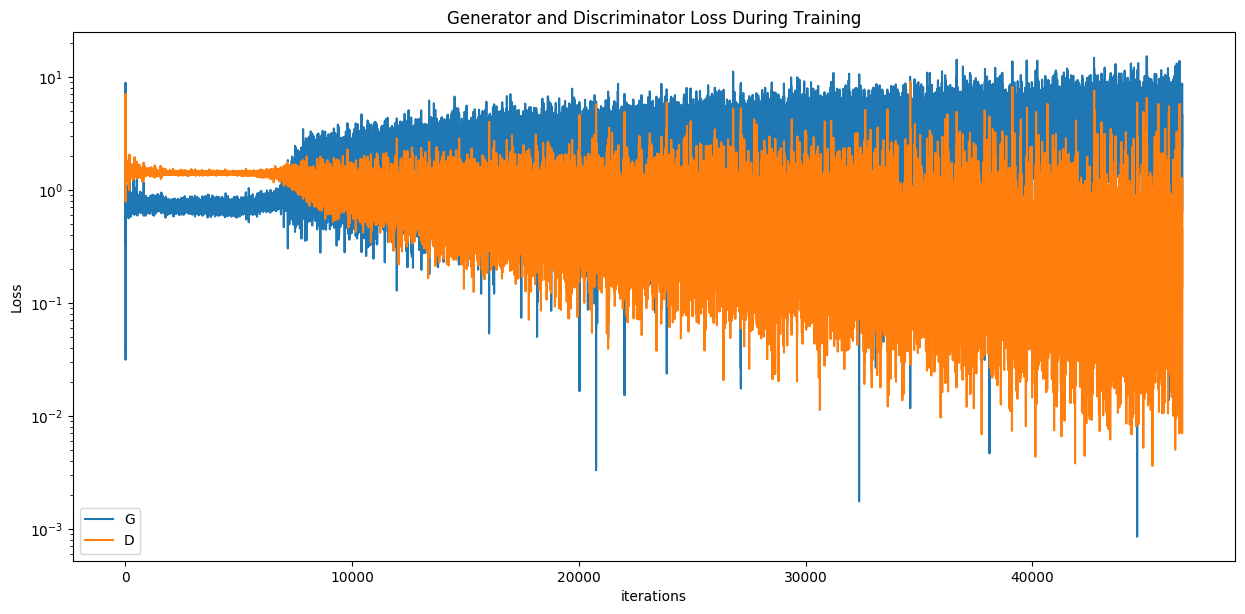

In [17]:
plt.figure(figsize=(15,7), dpi=100)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=32)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(16,8), dpi=128)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()